<a href="https://colab.research.google.com/github/Dasika-Vaishnavi/Project-Dharma/blob/main/Vakeel__Saab_ML_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# I refered to below notebook to try TFIDF and ML classification model
# https://www.kaggle.com/selener/multi-class-text-classification-tfidf

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df = pd.read_csv('/content/legal_text_classification.csv')
df.shape

(998, 4)

In [ ]:
df.head(2).T

,0,1
case_id,Case1,Case2
case_outcome,cited,cited
case_title,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...
case_text,Ordinarily that discretion will be exercised s...,The general principles governing the exercise ...


In [ ]:
df1 = df[['case_outcome', 'case_text']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['case_text'])]

# Renaming second column for a simpler name
df1.columns = ['Outcome', 'Text'] 

df1.shape

(994, 2)

In [ ]:
total = df1['Text'].notnull().sum()
round((total/len(df)*100),1)

99.6

In [ ]:
pd.DataFrame(df.case_outcome.unique()).values

array([['cited'],
       ['applied'],
       ['followed'],
       ['referred to'],
       ['related'],
       ['considered'],
       ['discussed'],
       ['distinguished'],
       ['affirmed']], dtype=object)

In [ ]:
df2 = df1.sample(5000, random_state=1, replace=True).copy()

In [ ]:
df2['category_id'] = df2['Outcome'].factorize()[0]
category_id_df = df2[['Outcome', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Outcome']].values)

df2.head()

,Outcome,Text,category_id
38,cited,Numerous cases have held that s 911A of the Ac...,0
237,cited,"Later, at 552-553, Menzies J said: The differe...",0
910,followed,appellant submits that the approach of the Tri...,1
73,cited,Matters of policy and implementation of policy...,0
769,referred to,The next question is whether the error of the ...,2


Text(0.5, 0, 'Number of ocurrences')

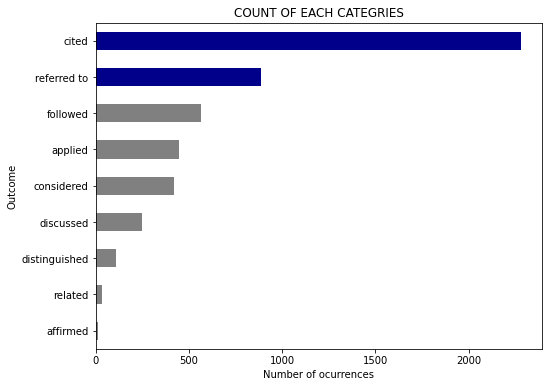

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','darkblue','darkblue','darkblue']
df2.groupby('Outcome').Text.count().sort_values().plot.barh(ylim=0, color=colors, title= 'COUNT OF EACH CATEGRIES')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')


features = tfidf.fit_transform(df2.Text).toarray()

labels = df2.category_id

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 5000 Text is represented by 64342 features (TF-IDF score of unigrams and bigrams)


In [ ]:
N = 3
for Outcome, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Outcome))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> affirmed:
  * Most Correlated Unigrams are: kosovo, forced, loan
  * Most Correlated Bigrams are: proceedings fact, conveniently 17, subject present

==> applied:
  * Most Correlated Unigrams are: mzwqh, mzwxc, relitigate
  * Most Correlated Bigrams are: attempt relitigate, unlawful discrimination, claim unlawful

==> cited:
  * Most Correlated Unigrams are: jennings, bankruptcy, health
  * Most Correlated Bigrams are: litigation privilege, bankruptcy notice, health plus

==> considered:
  * Most Correlated Unigrams are: 170eha, fenech, jr
  * Most Correlated Bigrams are: genuine dispute, unreported industrial, relations court

==> discussed:
  * Most Correlated Unigrams are: fees, stevenson, jolly
  * Most Correlated Bigrams are: stevenson 1937, clr 80, dividend debt

==> distinguished:
  * Most Correlated Unigrams are: stake, 673, matthew
  * Most Correlated Bigrams are: right special, special applicant, private right

==> followed:
  * Most Correlated Unigrams are: creditor, ab

In [ ]:
X = df2['Text']
y = df2['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.9398,0.006419
LogisticRegression,0.8996,0.008355
MultinomialNB,0.8122,0.002049
RandomForestClassifier,0.5070,0.008000


Text(0.5, 1.0, 'MEAN ACCURACY (cv = 5)\n')

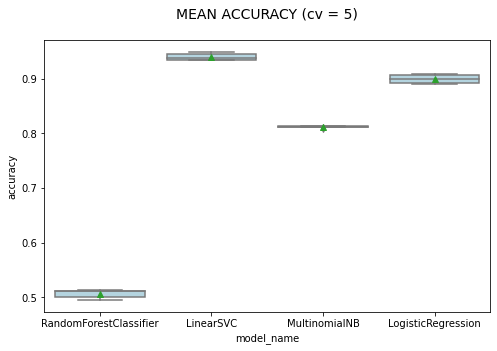

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14)

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Outcome'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

        cited       0.87      0.97      0.92       589
     followed       0.85      0.87      0.86       115
  referred to       0.92      0.94      0.93       231
    discussed       0.98      0.80      0.88        69
      applied       0.98      0.81      0.89       100
   considered       0.92      0.72      0.81       100
     affirmed       0.00      0.00      0.00         6
      related       1.00      0.83      0.91         6
distinguished       1.00      0.56      0.72        34

     accuracy                           0.90      1250
    macro avg       0.84      0.72      0.77      1250
 weighted avg       0.90      0.90      0.89      1250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


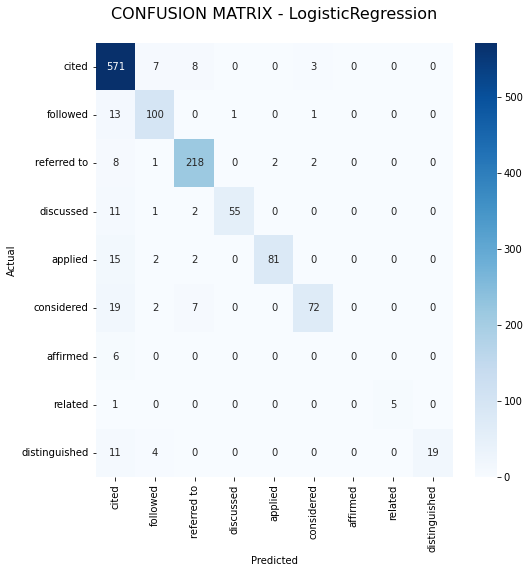

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Outcome.values, 
            yticklabels=category_id_df.Outcome.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);